In [1]:
import numpy as np
import matplotlib.pyplot as plt
from stochastic.processes import FractionalBrownianMotion
from utils import *

# Training Notebook:

This notebook trains the model from scratch on a large number of simulated fractional Brownian motion trajectories. It starts by generating a large dataset, it converts data into the correct shape and it instantiates efficient pytorch dataset and dataloader objects. The training loop is then run and evaluated.

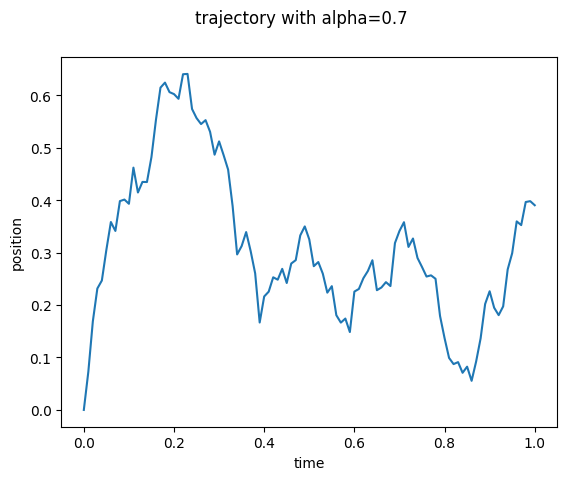

In [2]:
# Show a sample realization of a trajectory

alpha=1.4

f = FractionalBrownianMotion(hurst=0.5*alpha, t=1)
# Generate a fBm realization
fbm_sample = f.sample(100)
# Get the times associated with the fBm
t_values = f.times(100)
plt.plot(t_values[:10000], fbm_sample[:10000])
plt.xlabel('time')
plt.ylabel('position')
plt.suptitle("trajectory with alpha=0.7")
plt.show()

In [3]:
# Find the best device to train the model on
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")


Using cuda device


In [4]:
# Generate training and test datasets, convert them into pytorch friendly datasets and dataloader objects, instantiate the model, the loss function and the optimizer.

N_SIMS=60000 # Number of simulations
trajectory_length=100 # Number of steps to be sampled in each trajectory
batch_size=10 # Number of samples to be used in each iteration during the training loop
learning_rate=1e-3


X_train, Y_train, X_test, Y_test = generate_dataset(N_SIMS, trajectory_length)

train_data=SimulationDatset(X_train, Y_train)
train_loader=DataLoader(train_data, batch_size=batch_size)

test_data=SimulationDatset(X_test, Y_test)
test_loader=DataLoader(test_data, batch_size=batch_size)


model=DeepBrownianEncoder(embedding_dim=30, num_layers=1, num_heads=2).to(device)
loss_fn=nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

Simulations Generated: 0
Simulations Generated: 10000
Simulations Generated: 20000
Simulations Generated: 30000
Simulations Generated: 40000
Simulations Generated: 50000


In [5]:
# Run the training loop.

epochs = 3
losses=[]
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    loss = train(train_loader, model, loss_fn, optimizer, device)
    losses += (loss)
    DatasetMAE(test_loader, model, device)
print("Done!")

Epoch 1
-------------------------------
loss: 0.605363  [   10/42000]
loss: 0.449418  [ 1010/42000]
loss: 0.619727  [ 2010/42000]
loss: 0.441940  [ 3010/42000]
loss: 0.417316  [ 4010/42000]
loss: 0.390616  [ 5010/42000]
loss: 0.509075  [ 6010/42000]
loss: 0.425532  [ 7010/42000]
loss: 0.287577  [ 8010/42000]
loss: 0.487167  [ 9010/42000]
loss: 0.334145  [10010/42000]
loss: 0.294588  [11010/42000]
loss: 0.307756  [12010/42000]
loss: 0.254845  [13010/42000]
loss: 0.335857  [14010/42000]
loss: 0.462574  [15010/42000]
loss: 0.347956  [16010/42000]
loss: 0.196223  [17010/42000]
loss: 0.343015  [18010/42000]
loss: 0.255063  [19010/42000]
loss: 0.334765  [20010/42000]
loss: 0.261908  [21010/42000]
loss: 0.265913  [22010/42000]
loss: 0.376523  [23010/42000]
loss: 0.245729  [24010/42000]
loss: 0.285144  [25010/42000]
loss: 0.251013  [26010/42000]
loss: 0.330153  [27010/42000]
loss: 0.338642  [28010/42000]
loss: 0.399580  [29010/42000]
loss: 0.222254  [30010/42000]
loss: 0.169316  [31010/42000]


In [8]:
len(losses)

12600

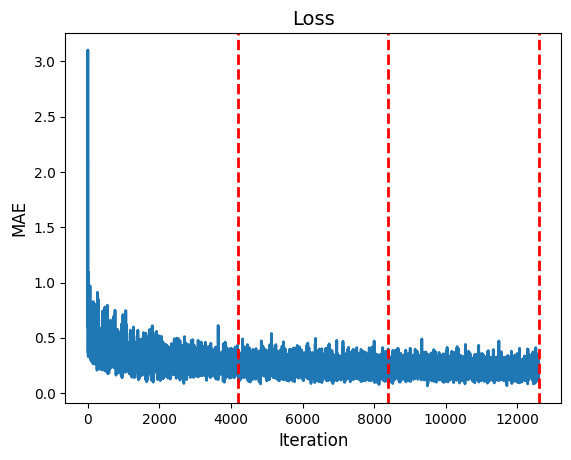

In [12]:
# Show the loss value as a function of the number of iterations in the training loop. Red dashed lines represent epochs.

plt.plot(losses, linewidth=2)
plt.xlabel('Iteration', fontsize=12)
plt.ylabel('MAE', fontsize=12)
plt.title('Loss', fontsize=14)
for e in range(1, epochs+1):
    plt.axvline(x=e*(0.7*N_SIMS/batch_size), color='red', linewidth=2, label='epoch', linestyle='--')
#plt.legend(fontsize=12)
plt.plot()

plt.savefig('media/training.png')

In [6]:
#Save model
torch.save(model.state_dict(), 'model/model_weights.pth')

## Animation

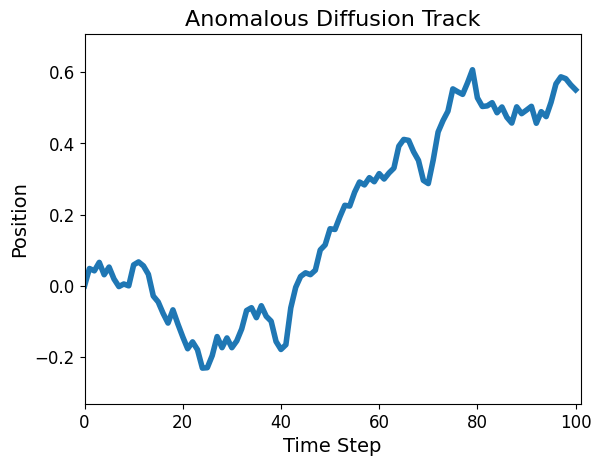

In [16]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np

alpha=1.4
f = FractionalBrownianMotion(hurst=0.5*alpha, t=1)
fbm_sample = f.sample(100)

# Create a figure and axis
fig, ax = plt.subplots()
ax.set_xlim(0, len(fbm_sample))
ax.set_ylim(min(fbm_sample) - 0.1, max(fbm_sample) + 0.1)
line, = ax.plot([], [], lw=4)


# Set title and labels
ax.set_title("Anomalous Diffusion Track", fontsize=16)
ax.set_xlabel("Time Step", fontsize=14)
ax.set_ylabel("Position", fontsize=14)

ax.tick_params(axis='both', labelsize=12)

def init():
    line.set_data([], [])
    return line,

def animate(i):
    x = np.arange(0, i+1)
    y = fbm_sample[:i+1]
    line.set_data(x, y)
    return line,

# Create the animation
anim = FuncAnimation(fig, animate, init_func=init, frames=len(fbm_sample), interval=70, blit=True)

# Save the animation as a GIF
anim.save('media/fbm.gif', writer='pillow')

plt.show()